In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("../incl/")

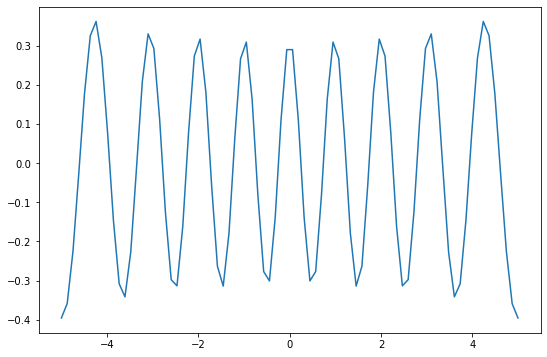

In [5]:
from scipy.special import eval_hermite

def get_N(n):
    return 1./np.sqrt(np.sqrt(np.pi)*2**n*np.math.factorial(n))

x = np.linspace(-5,5,80)

n = 20

h = eval_hermite(n,x)

H = get_N(n) * h * np.exp(-0.5*x**2)


plt.plot(x,H)
plt.show()

In [3]:

x = np.linspace(-100,100,10001)
x = x[1:]
dx = x[1]-x[0]

# print(x)

n1 = 80
n2 = 80

inner = get_N(n1)*eval_hermite(n1,x) @ ( get_N(n2)*eval_hermite(n2,x) * np.exp(-x**2) * dx)

print(inner)


1.0000000000005225


In [2]:
import ELPH_utils
runs = ELPH_utils.load_runs(filename='../../runs_n_kmax=80.npz')
# runs = runs[:100:1]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

data_matrix = np.concatenate(runs, axis=1)

1000 loaded with n_kmax = 80


H matrix rank: 27


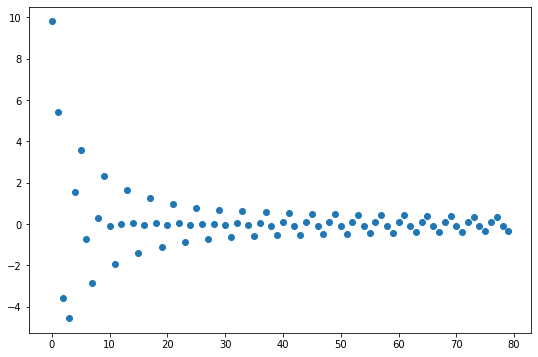

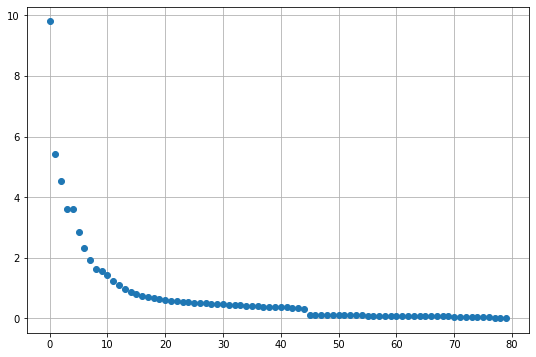

In [51]:
from ELPH_Dim_Reducer import Hermite


HermiteReducer = Hermite(sample_max=1.618,sorted=True, optimize=True)

HermiteReducer.train(data_matrix)

# plt.plot(HermiteReducer.H_matrix[119])
# plt.plot(HermiteReducer.H_matrix[118])
# plt.show()

print('H matrix rank:', np.linalg.matrix_rank(HermiteReducer.H_matrix))

# U,S,V = np.linalg.svd(HermiteReducer.H_matrix.T)
# plt.semilogy(S, 'o')
# plt.show()

plt.plot(HermiteReducer.mean_coefs,'o')
plt.show()

plt.grid()
plt.plot(np.abs(HermiteReducer.mean_coefs[HermiteReducer.sort_inds]),'o')
plt.show()


sample max: 1.618
H matrix rank: 27


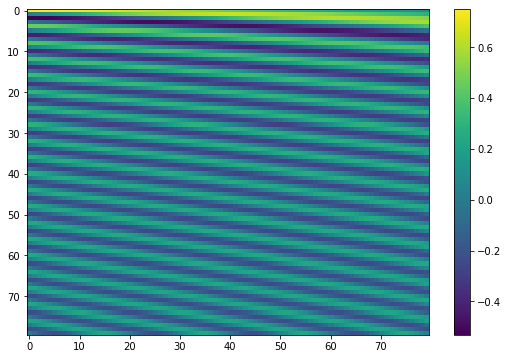

In [59]:
print('sample max:', HermiteReducer.sample_max)

print('H matrix rank:', np.linalg.matrix_rank(HermiteReducer.H_matrix[:80]))

plt.imshow(HermiteReducer.H_matrix, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()



# Q,R = np.linalg.qr(HermiteReducer.H_matrix.T)

# plt.imshow(Q.T, aspect='auto', interpolation='none')
# plt.colorbar()
# plt.show()


# print('Q matrix rank:', np.linalg.matrix_rank(Q.T))

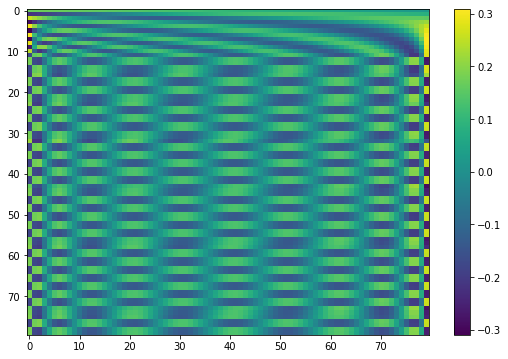

O matrix rank: 31


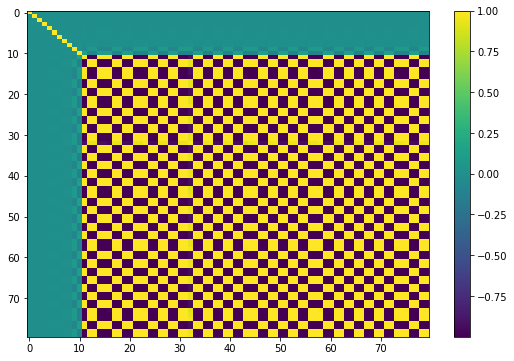

In [91]:
import numpy.linalg as la
def orthogonalize(U, eps=1e-15):
    """
    Orthogonalizes the matrix U (d x n) using Gram-Schmidt Orthogonalization.
    If the columns of U are linearly dependent with rank(U) = r, the last n-r columns 
    will be 0.
    
    Args:
        U (numpy.array): A d x n matrix with columns that need to be orthogonalized.
        eps (float): Threshold value below which numbers are regarded as 0 (default=1e-15).
    
    Returns:
        (numpy.array): A d x n orthogonal matrix. If the input matrix U's cols were
            not linearly independent, then the last n-r cols are zeros.
    """
    
    n = len(U[0])
    # numpy can readily reference rows using indices, but referencing full rows is a little
    # dirty. So, work with transpose(U)
    V = U.copy().T
    for i in range(n):
        prev_basis = V[0:i]     # orthonormal basis before V[i]
        coeff_vec = np.dot(prev_basis, V[i].T)  # each entry is np.dot(V[j], V[i]) for all j < i
        # subtract projections of V[i] onto already determined basis V[0:i]
        V[i] -= np.dot(coeff_vec, prev_basis).T
        if la.norm(V[i]) < eps:
            V[i][V[i] < eps] = 0.   # set the small entries to 0
        else:
            V[i] /= la.norm(V[i])
    return V.T

O = orthogonalize(HermiteReducer.H_matrix.T).T

plt.imshow(O, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


print('O matrix rank:', np.linalg.matrix_rank(O))

plt.imshow(O @ O.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

/var/folders/7g/q_bzf2x90tgdvp_0w5gv6m380000gn/T/ipykernel_97807/4019649248.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  w = v - np.sum( np.dot(v,b)*b for b in basis )


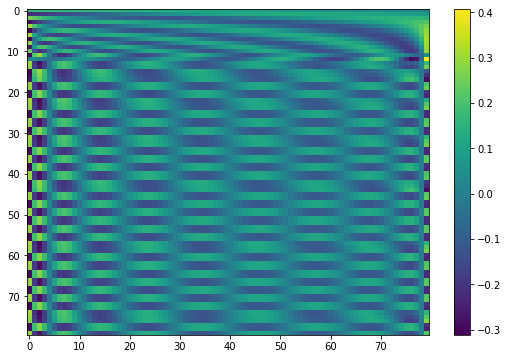

OO matrix rank: 31


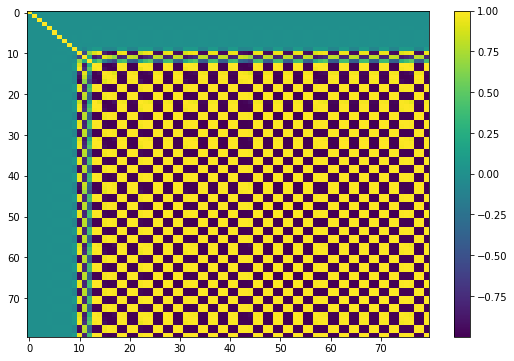

In [92]:
def gram_schmidt(vectors, eps=1e-10):
    basis = []
    for v in vectors:
        w = v - np.sum( np.dot(v,b)*b for b in basis ) 
        if (w > eps).any():  
            basis.append(w/np.linalg.norm(w))
    return np.array(basis)

OO = gram_schmidt(HermiteReducer.H_matrix)


plt.imshow(OO, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

print('OO matrix rank:', np.linalg.matrix_rank(OO))

plt.imshow(OO @ OO.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

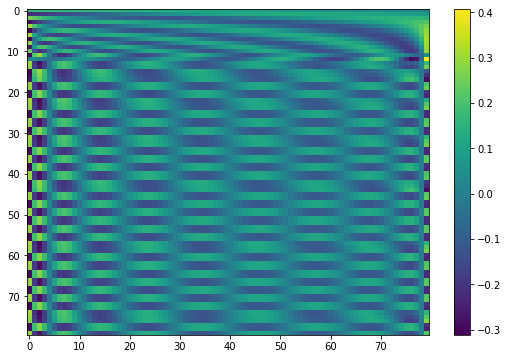

(80, 400)
(80, 400)


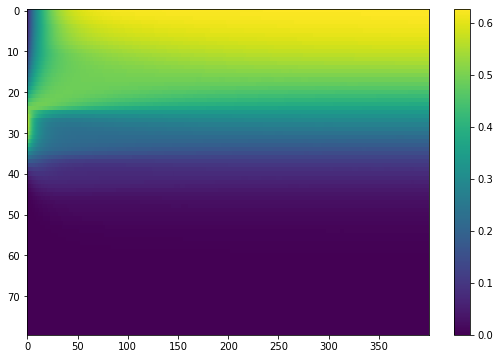

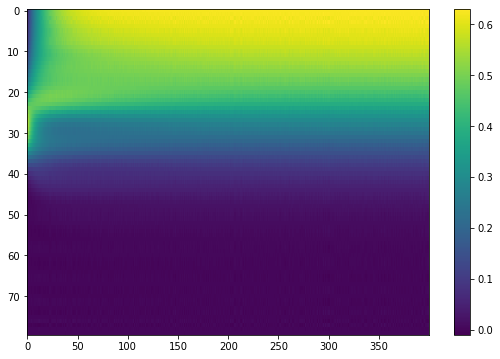

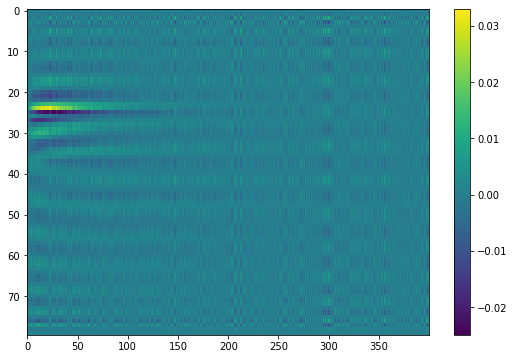

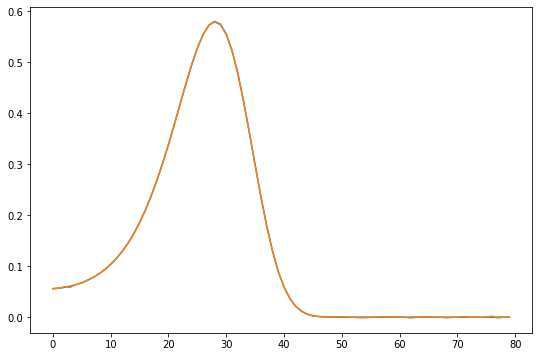

In [100]:
test = runs[55]


HermiteReducer.H_matrix = OO

plt.imshow(HermiteReducer.H_matrix, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


red_coef_matrix = HermiteReducer.reduce(test,80)
print(red_coef_matrix.shape)

recon = HermiteReducer.expand(red_coef_matrix)
print(recon.shape)




plt.imshow(test, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(recon, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(test - recon, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.plot(test[:,0])
plt.plot(recon[:,0])
plt.show()


# plt.imshow(np.abs(red_coef_matrix), aspect='auto', interpolation='none')
# plt.colorbar()
# plt.show()